(notebook:illustrative)=

# The Method of Moderation: Illustrative Notebook

In [1]:
# Import Econ-ARK styling and display header
from style import (
    HEADER_HTML_NOTEBOOK,
    apply_ark_style,
    apply_notebook_css,
)

# Apply Econ-ARK branding and styling
apply_ark_style()
apply_notebook_css()


# Display Econ-ARK header (for Jupyter notebooks)
from IPython.display import HTML, display

display(HTML(HEADER_HTML_NOTEBOOK))

**Author:** <span style="color: var(--ark-lightblue); font-weight: bold;">Alan Lujan</span>, <span style="color: var(--ark-blue); font-weight: bold;">Johns Hopkins University</span>

This notebook provides a pedagogical introduction to the Method of Moderation (MoM), a novel technique for solving consumption-saving models with superior accuracy and stability. We begin by motivating the problem that MoM solves: the "extrapolation problem" inherent in sparse-grid implementations of the Endogenous Grid Method (EGM). We then build the theoretical foundations for MoM, demonstrating how it leverages analytical bounds to ensure economically sensible behavior across the entire state space.

## Model Foundations: The Friedman-Muth Income Process

We adopt the canonical framework of {cite:t}`Friedman1957` and {cite:t}`Muth1960`: an agent receiving labor income subject to permanent and transitory shocks. The model implementation follows {cite:t}`SolvingMicroDSOPs`.

## The Extrapolation Problem in Consumption-Saving Models

The Method of Moderation (MoM) addresses the **extrapolation problem** in sparse-grid EGM implementations. EGM computes optimal consumption at finite grid points, but evaluating the policy function outside this grid via linear extrapolation can predict **negative precautionary saving**, violating established theory {cite:p}`Leland1968,Sandmo1970,Kimball1990`.

MoM operates in a transformed space defined by two analytical bounds from the buffer-stock saving literature {cite:p}`Carroll1997,StachurskiToda2019JET,MST2020JET`:

1. **The Optimist**: Ignores future income risk.
2. **The Pessimist**: Assumes worst-case income realizations.

The true consumption function lies between these extremes. MoM interpolates a **moderation ratio** guaranteed to remain within bounds, producing solutions that are economically coherent across the entire state space.

In [2]:
from __future__ import annotations

from moderation import (
    IndShockEGMConsumerType,
    IndShockMoMConsumerType,
    IndShockMoMStochasticRConsumerType,
)
from plotting import (
    GridType,
    plot_consumption_bounds,
    plot_cusp_point,
    plot_logit_function,
    plot_moderation_ratio,
    plot_mom_mpc,
    plot_precautionary_gaps,
    plot_stochastic_bounds,
    plot_value_functions,
)

# Model setup: Consumer with income uncertainty
params = {
    "CRRA": 2.0,
    "DiscFac": 0.96,
    "Rfree": [1.02],
    "TranShkStd": [1.0],
    "cycles": 1,
    "LivPrb": [1.0],
    "vFuncBool": True,
    "CubicBool": True,
    "PermGroFac": [1.0],
    "PermShkStd": [0.0],
    "TranShkCount": 7,
    "UnempPrb": 0.0,
    "BoroCnstArt": None,
}

# Dense grid for "truth" solution (high precision)
dense_grid = {"aXtraMin": 0.001, "aXtraMax": 40, "aXtraCount": 500, "aXtraNestFac": 3}

# Sparse grid for practical comparison (5 points only)
sparse_grid = {"aXtraMin": 0.001, "aXtraMax": 4, "aXtraCount": 5, "aXtraNestFac": -1}

# Solve three versions: Truth (dense EGM), Sparse EGM, Sparse MoM
IndShockTruth = IndShockEGMConsumerType(**(params | dense_grid))
IndShockTruth.solve()
IndShockTruthSol = IndShockTruth.solution[0]

# Unpack theoretical bounds (same for all methods)
TruthOpt = IndShockTruthSol.Optimist
TruthPes = IndShockTruthSol.Pessimist
TruthTight = IndShockTruthSol.TighterUpperBound

# Sparse EGM solution (standard approach)
IndShockEGMApprox = IndShockEGMConsumerType(**(params | sparse_grid))
IndShockEGMApprox.solve()
IndShockEGMApproxSol = IndShockEGMApprox.solution[0]

# Sparse MoM solution (same grid, different method)
IndShockMoMApprox = IndShockMoMConsumerType(**(params | sparse_grid))
IndShockMoMApprox.solve()
IndShockMoMApproxSol = IndShockMoMApprox.solution[0]

# Grid parameters for plotting
mNrmMax = IndShockMoMApproxSol.mNrmMin + IndShockMoMApprox.aXtraGrid.max()

## Consumption Function Analysis

The first set of figures will focus on the core of the consumption-saving problem: the consumption function $\cFunc(\mNrm)$, which maps market resources $\mNrm$ to consumption. We will demonstrate the extrapolation problem inherent in the standard EGM and show how the Method of Moderation resolves it by respecting theoretical bounds.

### Figure 1: The EGM Extrapolation Problem

The **precautionary saving gap** (optimist minus realist consumption) must be positive: income risk induces additional saving. As demonstrated in the paper and shown in [](#fig:egm-extrapolation-problem), standard EGM violates this constraint when extrapolating {cite:p}`carrollEGM`.

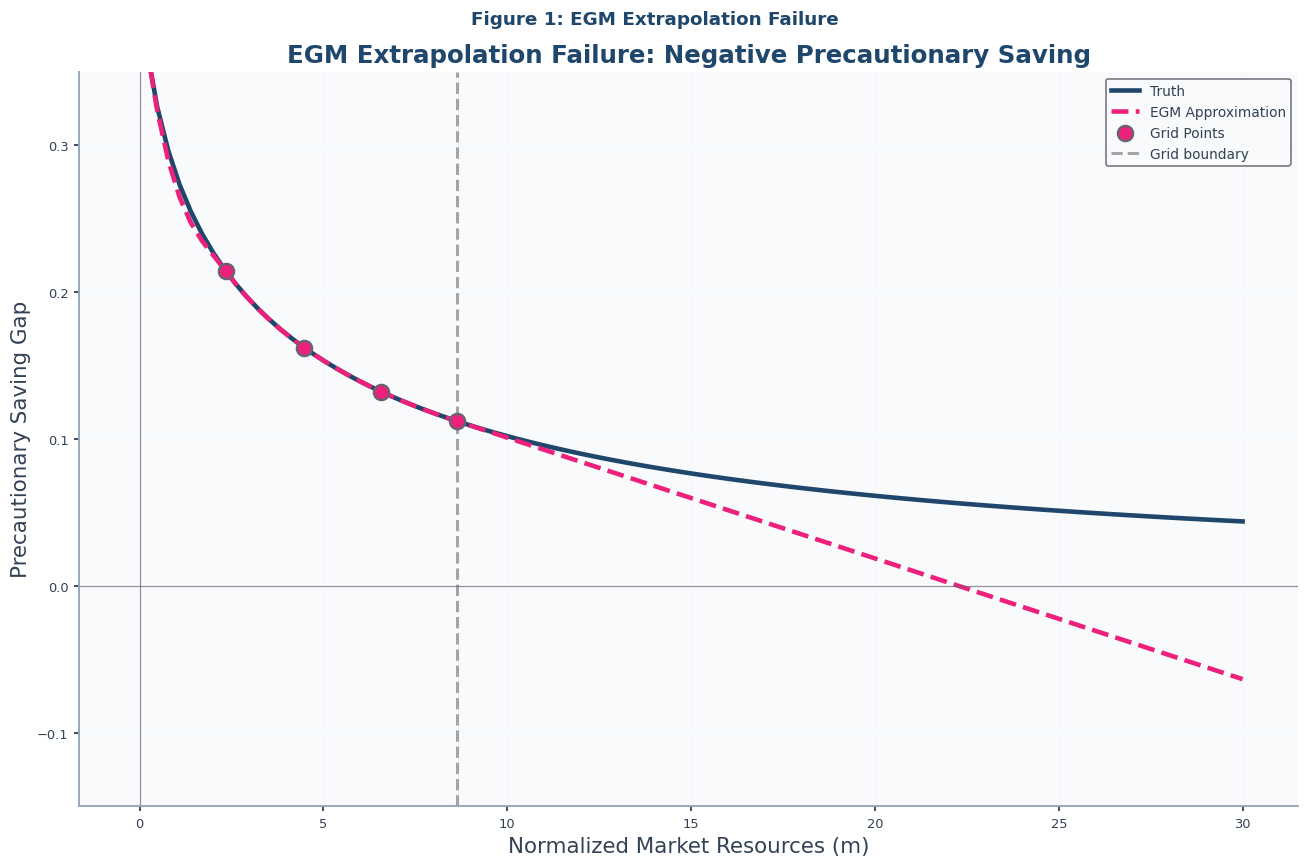

In [3]:
# | label: fig:egm-extrapolation-problem

# Figure 1: EGM Extrapolation Failure
plot_precautionary_gaps(
    truth_solution=IndShockTruthSol,
    approx_solutions=IndShockEGMApproxSol,
    title="Figure 1: EGM Extrapolation Failure",
    subtitle="EGM Extrapolation Failure: Negative Precautionary Saving",
)

```{attention} EGM vs MoM Extrapolation
Figure 1 demonstrates the core difference: **EGM** can predict negative precautionary saving (violating economic theory), while **MoM** maintains positive precautionary saving through asymptotically linear extrapolation.
```

```{seealso} EGM in the Literature
:class: dropdown

The Endogenous Grid Method ({cite:t}`carrollEGM`) is a powerful and widely-used tool in computational economics. Its applications have been extended to solve multi-dimensional problems {cite:p}`BarillasFV2007`, models with occasionally binding constraints {cite:p}`HintermaierKoeniger2010`, non-smooth and non-concave problems {cite:p}`Fella2014`, and discrete-continuous choice models {cite:p}`IskhakovRustSchjerning2017`. For a comprehensive treatment of the theory and practice of EGM, see {cite:p}`White2015`.

A critical step in implementing any numerical solution is the discretization of continuous stochastic processes. Standard methods for discretizing income shocks include those proposed by {cite:p}`TauchenHussey1991` and {cite:p}`tauchen1986`.
```

### Figure 2: Truth Bounded by Theory

The optimal consumption function is bounded by analytical optimist and pessimist solutions. [](#fig:truth-bounded-by-theory) ({ref}`Figure 2 <fig:IntExpFOCInvPesReaOptNeedHi>` in the paper) confirms the high-precision "truth" lies between these bounds.

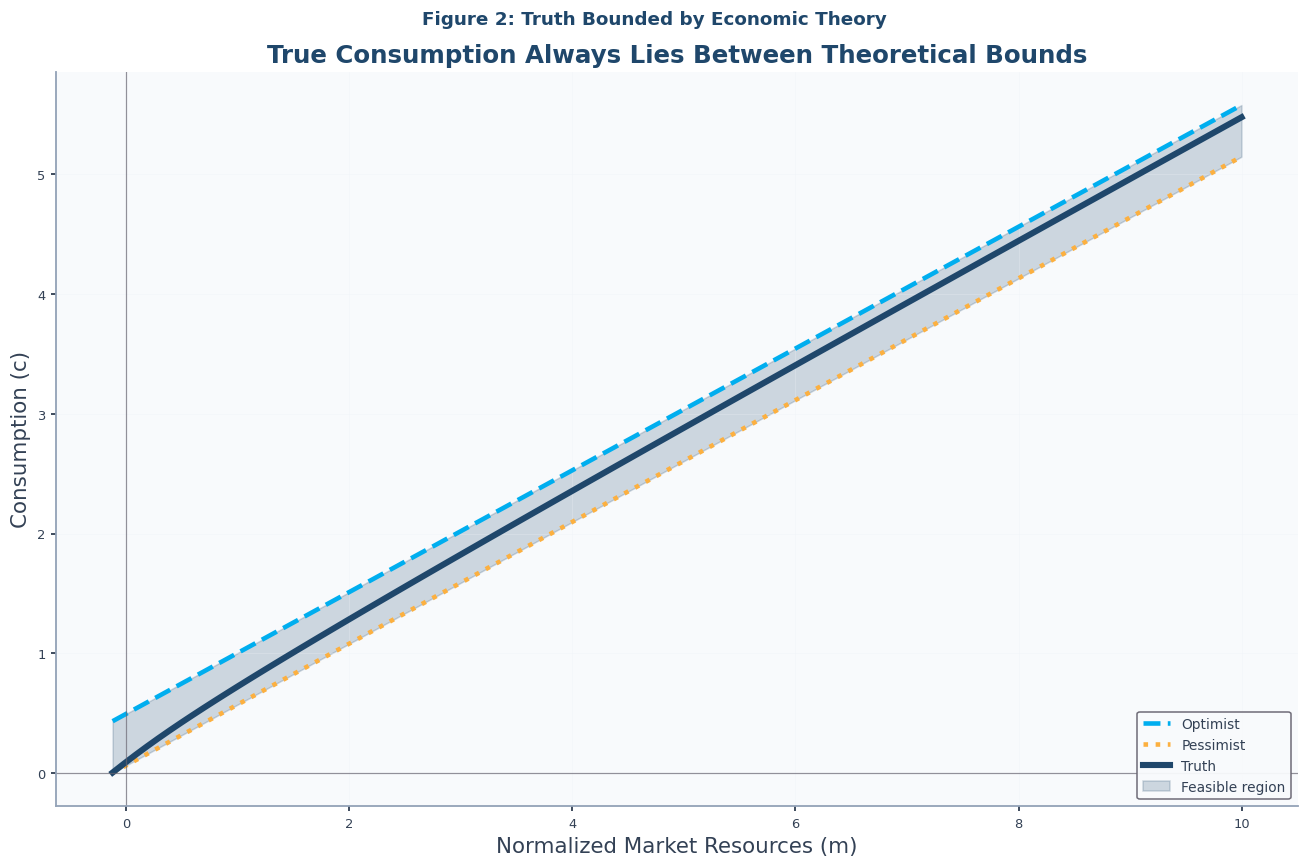

In [4]:
# | label: fig:truth-bounded-by-theory

# Figure 2: Truth Bounded by Theory
plot_consumption_bounds(
    solution=IndShockTruthSol,
    title="Figure 2: Truth Bounded by Economic Theory",
    subtitle="True Consumption Always Lies Between Theoretical Bounds",
    show_grid_points=False,  # Truth solution has too many grid points to display clearly
)

```{important} Key Theoretical Insight
The constraint $\cFuncPes(\mNrm) \leq \cFuncReal(\mNrm) \leq \cFuncOpt(\mNrm)$ is the foundation for MoM {cite:p}`CarrollShanker2024`. The lower bound arises from the natural borrowing constraint in incomplete markets models {cite:p}`Aiyagari1994,Huggett1993,Zeldes1989,Deaton1991`.
```

### Figure 3: Method of Moderation Solution

MoM interpolates a **moderation ratio** in a transformed space that guarantees bound compliance. [](#fig:mom-solution) ({ref}`Figure 3 <fig:ExtrapProblemSolved>` in the paper) shows MoM maintains positive precautionary saving even far beyond the computed grid.

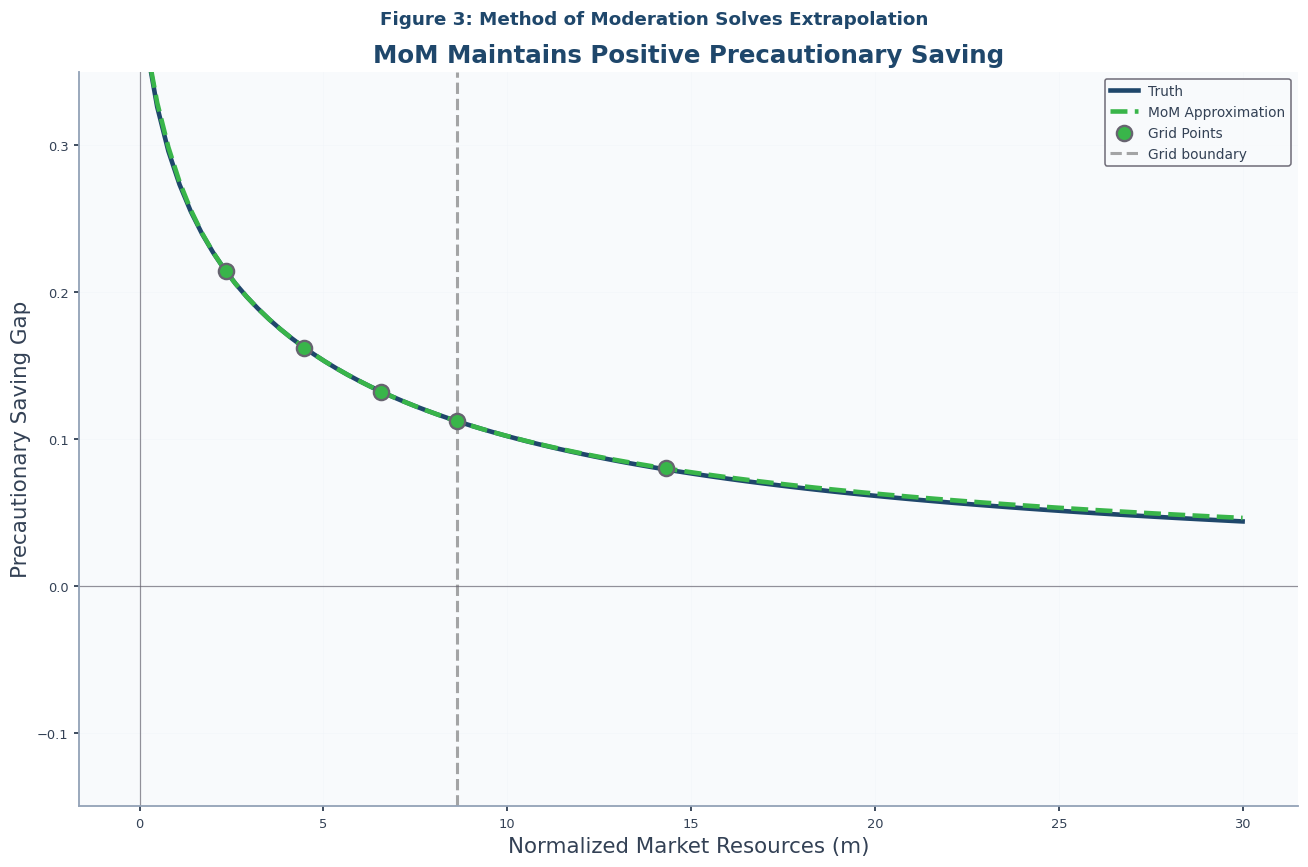

In [5]:
# | label: fig:mom-solution

# Figure 3: Method of Moderation Success
plot_precautionary_gaps(
    truth_solution=IndShockTruthSol,
    approx_solutions=IndShockMoMApproxSol,
    title="Figure 3: Method of Moderation Solves Extrapolation",
    subtitle="MoM Maintains Positive Precautionary Saving",
)

```{tip} Method of Moderation Success
MoM maintains positive precautionary saving when extrapolating far beyond its computed grid, matching high-precision truth.
```

MoM builds on EGM's computational efficiency while enforcing theoretical bounds. See [the paper's algorithm](../content/paper/moderation_letters.md#the-method-of-moderation).

(notebook:algorithm)=

```{hint} MoM Algorithm Details
:class: dropdown

MoM steps (notation matches the paper):
1. Solve standard EGM for realist consumption at gridpoints
2. Transform to $\logmNrmEx = \log(\mNrm - \mNrmMin)$
3. Compute $\modRte(\logmNrmEx) = (\cFuncReal - \cFuncPes)/(\cFuncOpt - \cFuncPes) \in [0,1]$ (Eq. {eq}`eq:modRte`)
4. Apply logit: $\logitModRte = \log(\modRte/(1-\modRte))$
5. Interpolate $\logitModRte(\logmNrmEx)$ with derivatives
6. Reconstruct: $\cFuncReal = \cFuncPes + \modRte \cdot (\cFuncOpt - \cFuncPes)$

This ensures bound compliance via asymptotically linear extrapolation, as derived in the paper. HARK uses **cubic Hermite interpolation** {cite:p}`Fritsch1980,FritschButland1984` for accuracy; see {cite:p}`Santos2000,JuddMaliarMaliar2017` on function approximation and error bounding.
```

```{note} The Transformation
The logit maps $\modRte \in (0,1)$ to $\logitModRte \in (-\infty, +\infty)$ and becomes asymptotically linear with positive slope $\logitModRteMu > 0$ as wealth increases.
```

### Figure 4: MoM Consumption Function

[](#fig:mom-consumption-function) ({ref}`Figure 4 <fig:IntExpFOCInvPesReaOptNeed45>` in the paper) shows MoM consumption between optimist and pessimist bounds, plus a **tighter upper bound** derived from $\MPCmax$ near the borrowing constraint {cite:p}`Carroll2001MPCBound,MaToda2021SavingRateRich,CarrollToche2009`. The cusp intersection is given by {eq}`eq:mNrmCusp`.

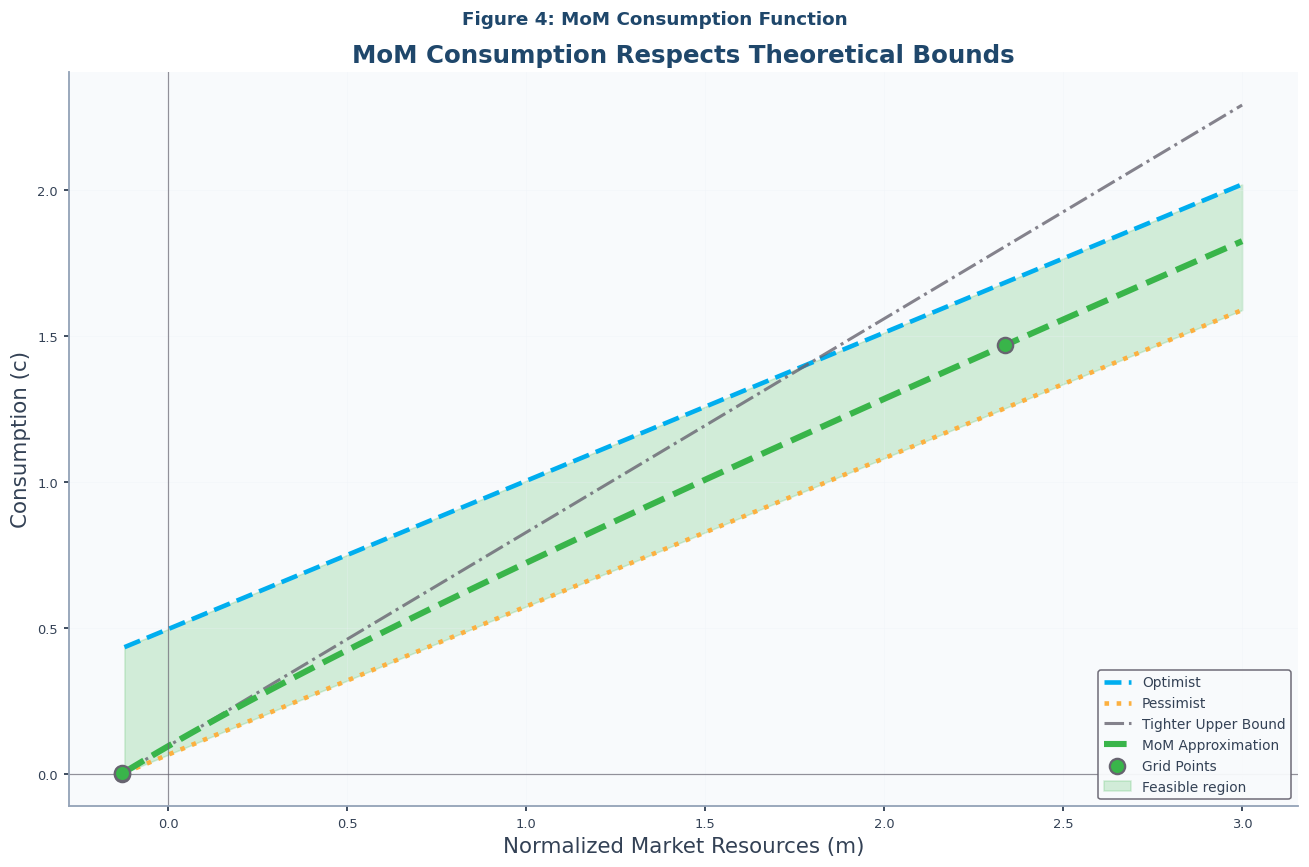

In [6]:
# | label: fig:mom-consumption-function

# Figure 4: MoM Consumption Function
plot_consumption_bounds(
    solution=IndShockMoMApproxSol,
    title="Figure 4: MoM Consumption Function",
    subtitle="MoM Consumption Respects Theoretical Bounds",
    m_max=3.0,
    show_tight_bound=True,
)

**Bound Preservation**: MoM consumption stays within theoretical bounds and below tight bound.

### Figure 5: Direct Method Comparison

[](#fig:direct-comparison) compares EGM and MoM precautionary gaps against the high-precision truth. Both approximations use identical 5-point sparse grids; the difference in extrapolation behavior is attributable solely to the method.

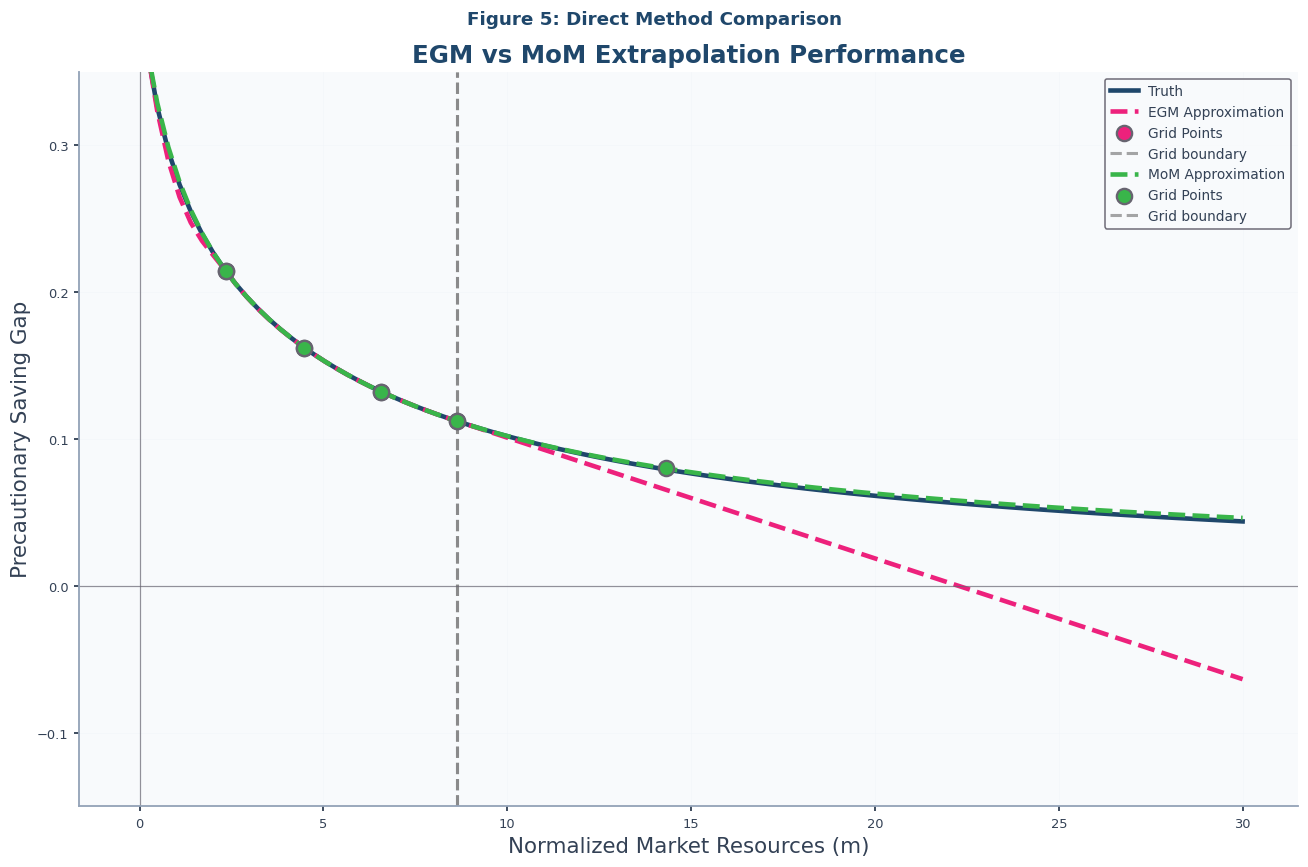

In [7]:
# | label: fig:direct-comparison

# Figure 5: Direct Method Comparison
plot_precautionary_gaps(
    truth_solution=IndShockTruthSol,
    approx_solutions=[IndShockEGMApproxSol, IndShockMoMApproxSol],
    title="Figure 5: Direct Method Comparison",
    subtitle="EGM vs MoM Extrapolation Performance",
)

```{important} The Decisive Advantage
Given identical sparse grids, EGM produces negative precautionary saving while MoM maintains positive values matching the truth.
```

## Method of Moderation Framework

### Figure 6: Moderation Ratio Function $\modRte(\mNrm)$

::::{admonition} Definition: The Moderation Ratio
:class: note

The **moderation ratio** (Eq. {eq}`eq:modRte`):

$$
\modRte(\mNrm) = \frac{\cFuncReal(\mNrm) - \cFuncPes(\mNrm)}{\cFuncOpt(\mNrm) - \cFuncPes(\mNrm)} \in (0,1)
$$

This ratio is strictly between 0 and 1 due to prudence {cite:p}`CarrollKimball1996`. At $\modRte = 0$ the realist behaves like the pessimist (maximum precautionary saving); at $\modRte = 1$ like the optimist (no precautionary saving). [](#fig:moderation-ratio) plots this ratio across wealth levels.
::::

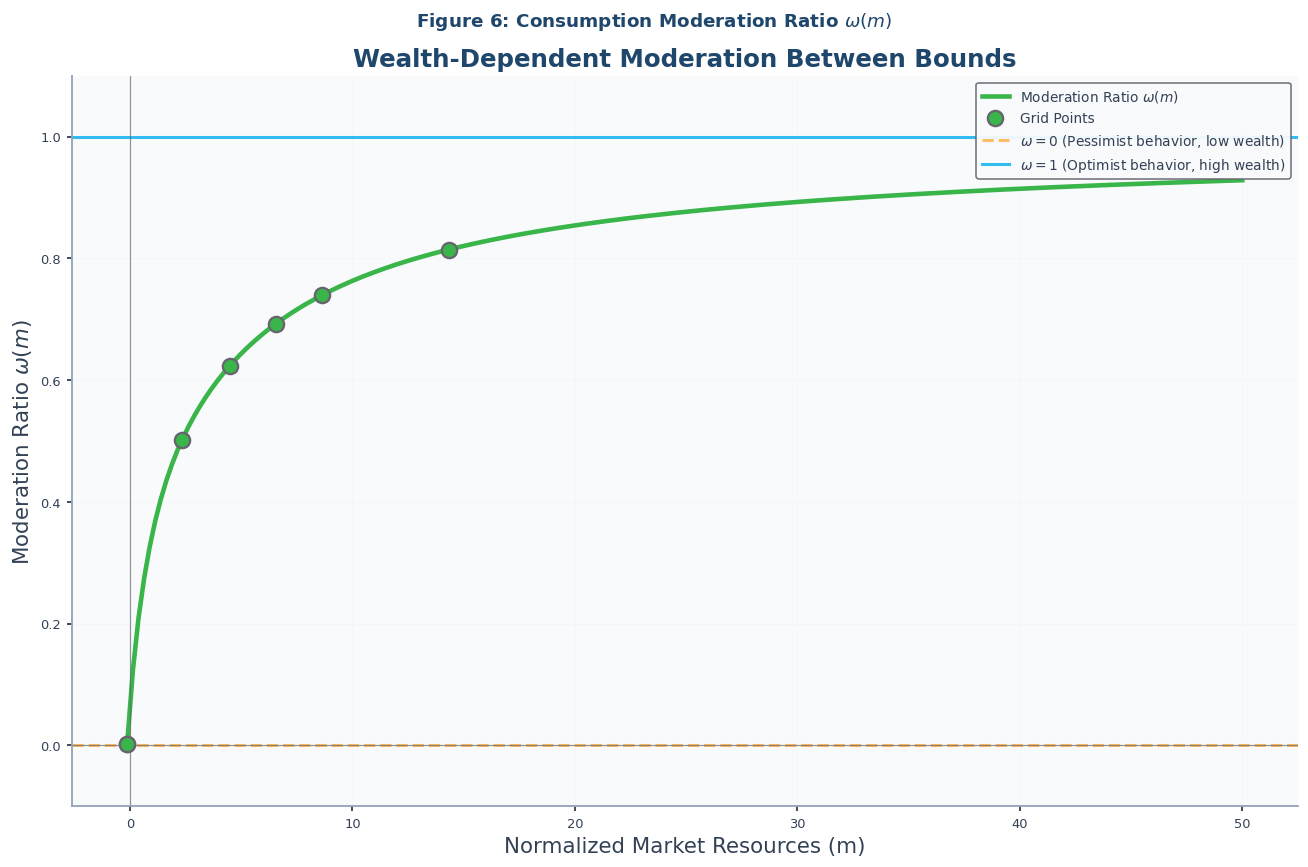

In [8]:
# | label: fig:moderation-ratio

# Figure 6: Moderation Ratio Function
plot_moderation_ratio(
    solution=IndShockMoMApproxSol,
    title=r"Figure 6: Consumption Moderation Ratio $\omega(m)$",
    subtitle="Wealth-Dependent Moderation Between Bounds",
    m_max=50,
    grid_type=GridType.CONSUMPTION,
)

```{note} Economic Interpretation of $\modRte(\mNrm)$
$\modRte \to 1$ at high wealth (approaches optimist), $\modRte \to 0$ at low wealth (approaches pessimist). This monotonic pattern ensures proper economic behavior across the wealth distribution.
```

### Figure 7: The Logit Transformation

::::{admonition} Definition: The Logit Transformation
:class: note

The **logit transformation** (Eq. {eq}`eq:chi`) maps the bounded ratio to an unbounded space:

$$
\logitModRte(\logmNrmEx) = \log\left(\frac{\modRte(\logmNrmEx)}{1 - \modRte(\logmNrmEx)}\right)
$$

where $\logmNrmEx = \log(\mNrm - \mNrmMin)$. As [](#fig:logit-transformation) shows, $\logitModRte$ is nearly linear, making it well-suited for interpolation.
::::

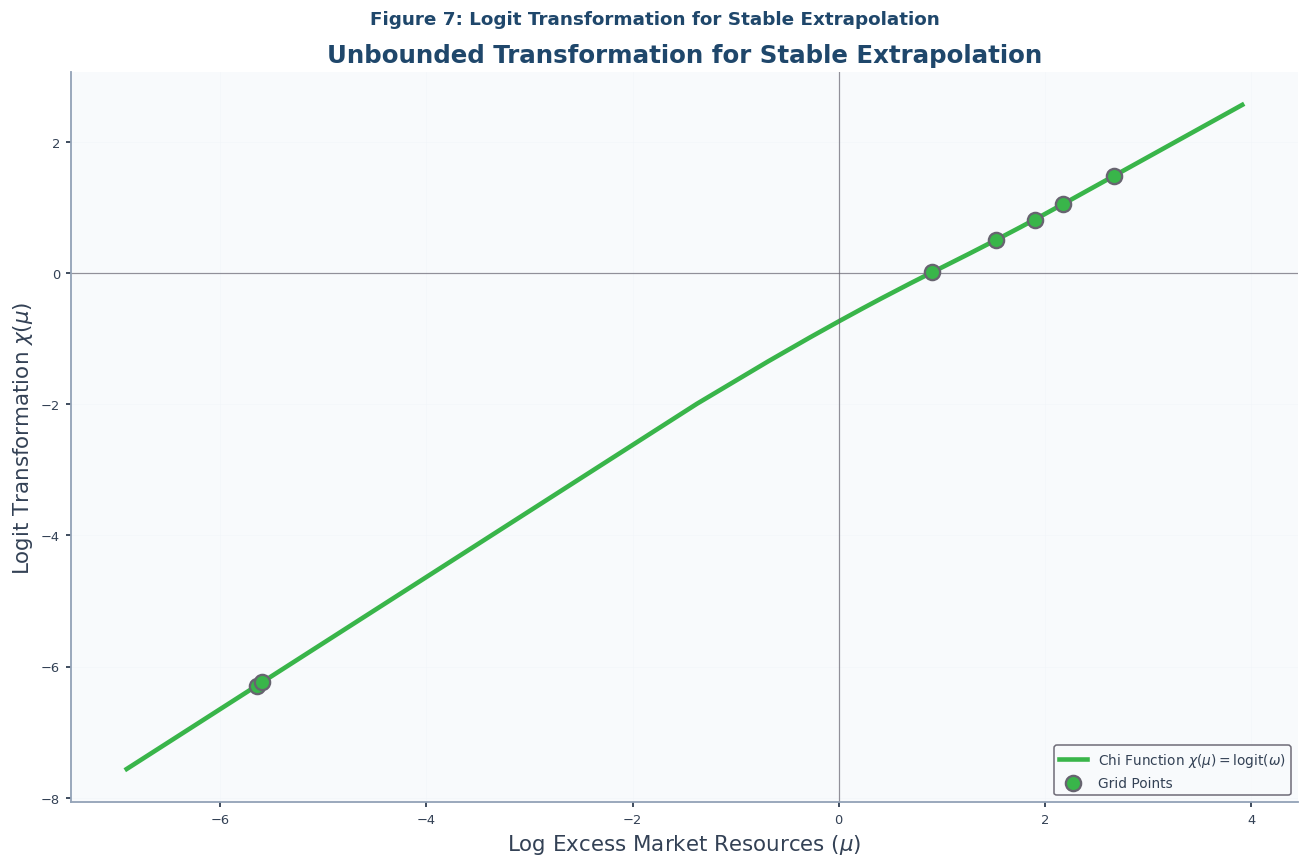

In [9]:
# | label: fig:logit-transformation

# Figure 7: Logit Transformation Function
plot_logit_function(
    solution=IndShockMoMApproxSol,
    title="Figure 7: Logit Transformation for Stable Extrapolation",
    subtitle="Unbounded Transformation for Stable Extrapolation",
    m_max=50,
)

```{important} Why Asymptotic Linearity Matters
As $\logmNrmEx \to \infty$, $\logitModRte$ becomes linear with slope $\logitModRteMu > 0$. This prevents extrapolation errors, ensures smooth convergence to the optimist bound, and maintains numerical stability.
```

```{note} Properties of $\logitModRte(\logmNrmEx)$
Unbounded domain $(-\infty, \infty)$, monotonically increasing, asymptotically linear. $\logitModRte > 0$ indicates behavior closer to optimist; $\logitModRte < 0$ closer to pessimist.
```

## Function Properties and Bounds

### Figure 8: MoM MPC Bounded by Theory

The **MPC** ($\partial \cNrm / \partial \mNrm$) is bounded between $\MPCmin$ (optimist) and $\MPCmax$ (at the borrowing constraint), as detailed in {ref}`the paper <a-tighter-upper-bound>` and Eq. {eq}`eq:MPCModeration` {cite:p}`Carroll2001MPCBound`. [](#fig:mpc-bounds) confirms MoM respects these bounds.

```{tip} Policy Applications
Bounded MPC estimates prevent nonsensical policy multipliers in DSGE models. MoM ensures economically meaningful MPCs for policy analysis.
```

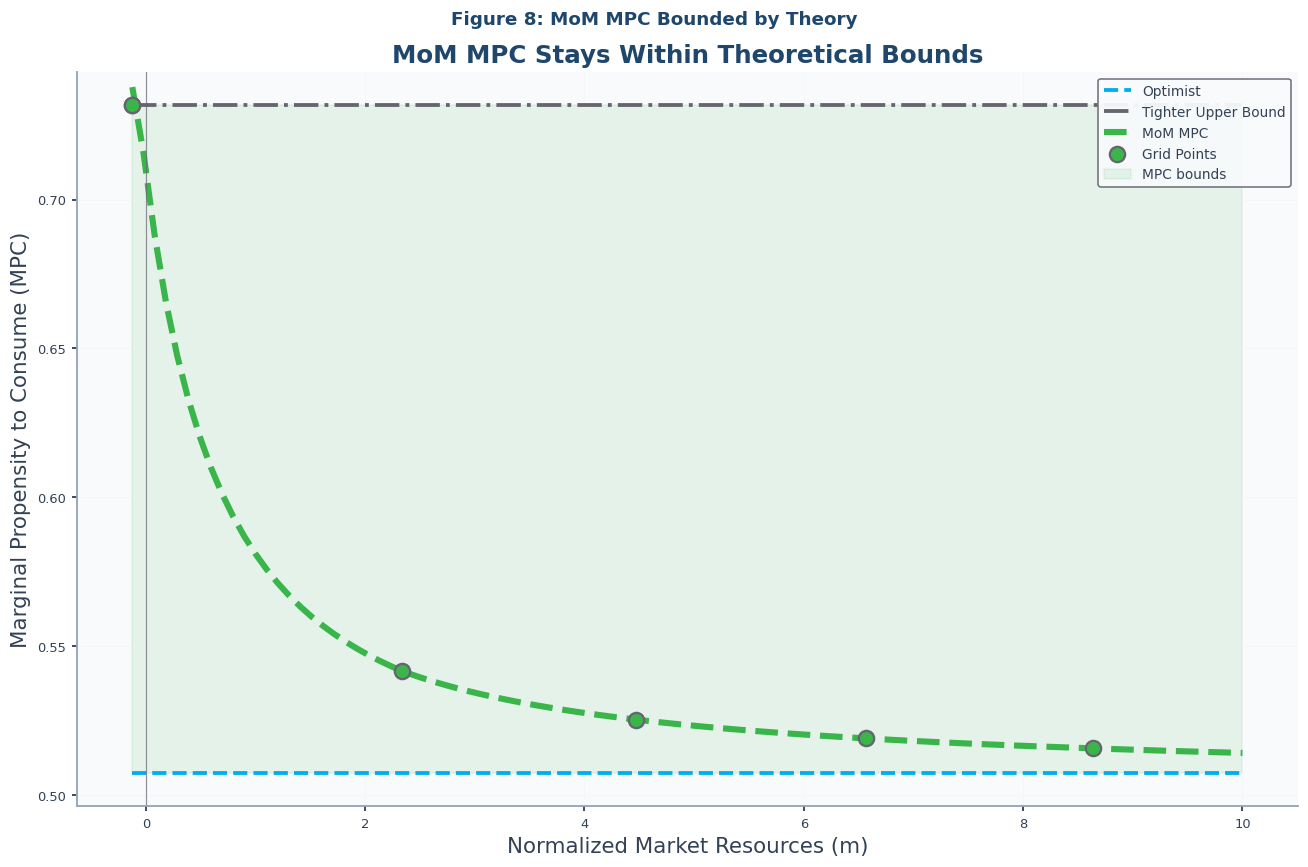

In [10]:
# | label: fig:mpc-bounds

# Figure 8: MoM MPC Bounds
plot_mom_mpc(
    solution=IndShockMoMApproxSol,
    title="Figure 8: MoM MPC Bounded by Theory",
    subtitle="MoM MPC Stays Within Theoretical Bounds",
)

```{hint} MPC Economic Interpretation
MoM MPC declines with $\mNrm$: poor consumers spend windfalls immediately (MPC $\to \MPCmax$), wealthy consumers save them (MPC $\to \MPCmin$), reflecting diminishing marginal utility.
```

### Figure 9: Value Functions Bounded by Theory

The **value function** $\vFunc(\mNrm)$ is also bounded by optimist and pessimist solutions {cite:p}`Aiyagari1994,Huggett1993`. [](#fig:value-functions) compares truth, EGM, and MoM value functions.

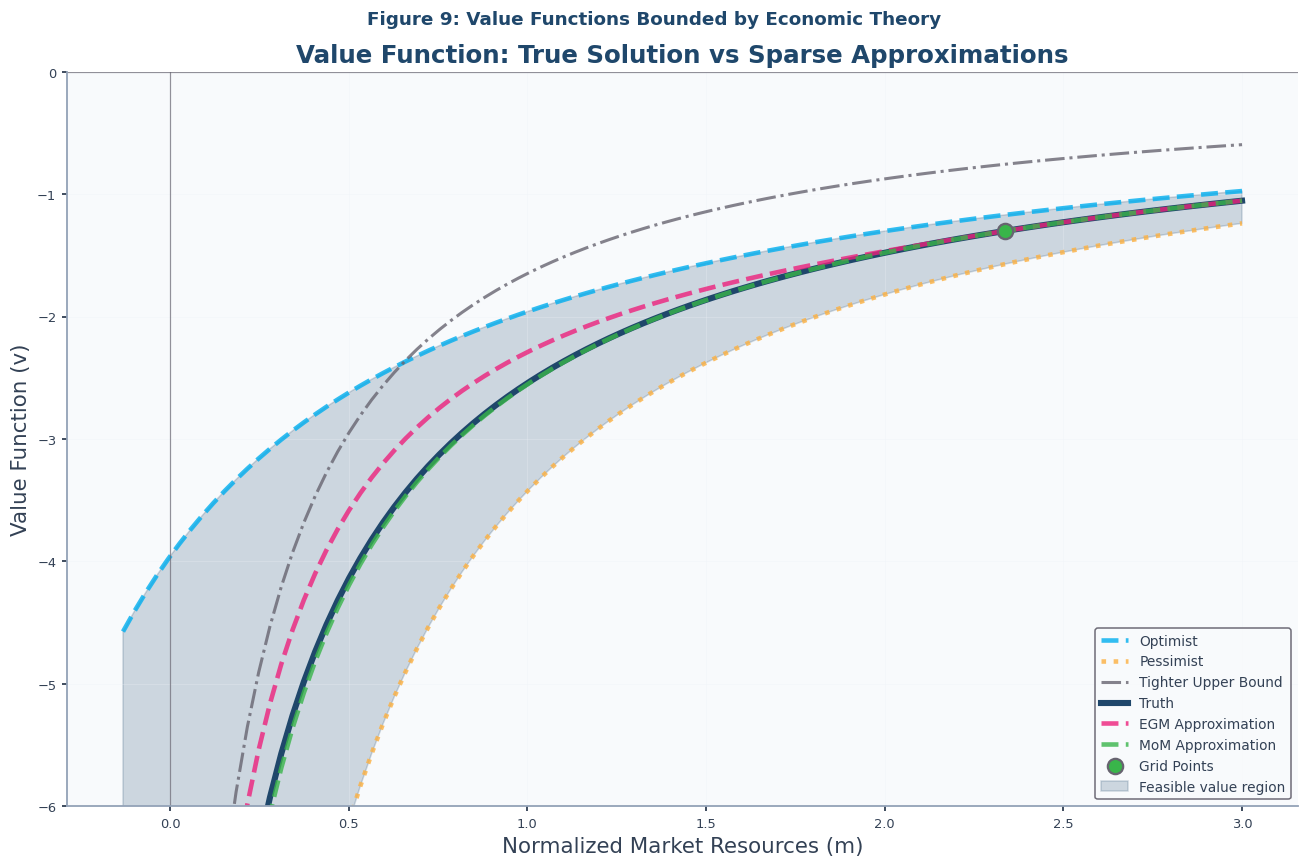

In [11]:
# | label: fig:value-functions

# Figure 9: Value Functions
plot_value_functions(
    truth_solution=IndShockTruthSol,
    title="Figure 9: Value Functions Bounded by Economic Theory",
    subtitle="Value Function: True Solution vs Sparse Approximations",
    egm_solution=IndShockEGMApproxSol,
    mom_solution=IndShockMoMApproxSol,
)

```{note} Value Function Interpretation
Both approximations use 5 sparse grid points. MoM stays closer to truth while respecting bounds. The optimist-pessimist gap represents the **cost of uncertainty**.
```

```{hint} Economic Insight
Uncertainty matters most at low wealth where buffers are small; the optimist-pessimist gap narrows with wealth as assets provide natural insurance.
```

### Figure 10: Inverse Value Functions $\vInv(\mNrm)$

The **inverse value function** $\vInv(\mNrm) = \uFunc^{-1}(\vFunc(\mNrm))$ gives the consumption equivalent of lifetime utility. It is more linear than $\vFunc(\mNrm)$ near the borrowing constraint, making it better suited for interpolation. [](#fig:inverse-value-functions) compares the three solutions.

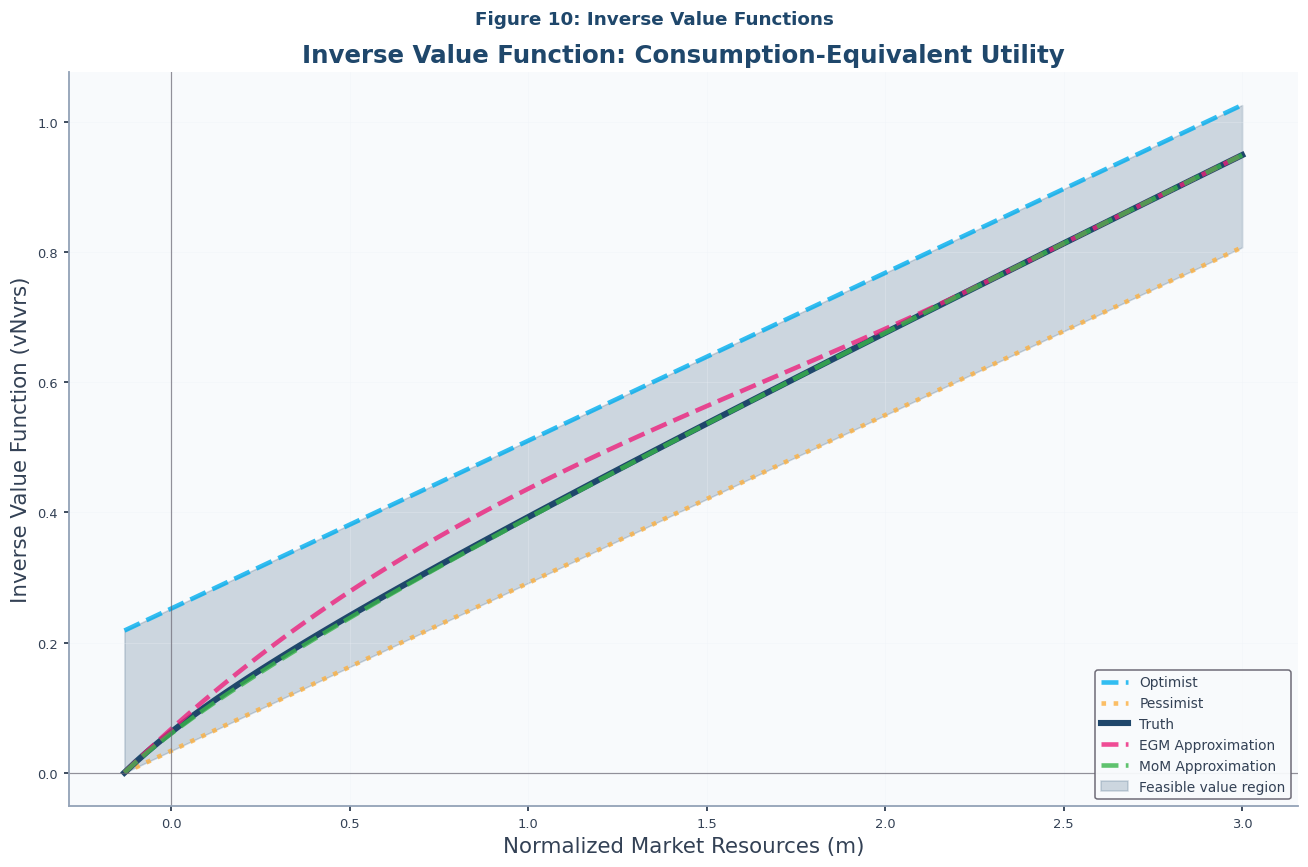

In [12]:
# | label: fig:inverse-value-functions

# Figure 10: Inverse Value Functions
plot_value_functions(
    truth_solution=IndShockTruthSol,
    title="Figure 10: Inverse Value Functions",
    subtitle="Inverse Value Function: Consumption-Equivalent Utility",
    inverse=True,
    egm_solution=IndShockEGMApproxSol,
    mom_solution=IndShockMoMApproxSol,
)

```{note} Inverse Value Function Interpretation
The inverse transformation converts utility to consumption units: $\vInv(5) = 0.8$ means 5 units of wealth provides lifetime utility equivalent to consuming 0.8 forever. HARK uses this more linear representation for interpolation.
```

### Figure 11: Value Function Moderation Ratio

MoM applies to any bounded function. The **inverse value function moderation ratio** (Eq. {eq}`eq:valModRteReal`):

$$
\valModRte(\mNrm) = \frac{\vInvReal(\mNrm) - \vInvPes(\mNrm)}{\vInvOpt(\mNrm) - \vInvPes(\mNrm)}
$$

follows the same pattern as the consumption ratio, as shown in [](#fig:value-moderation-ratio).

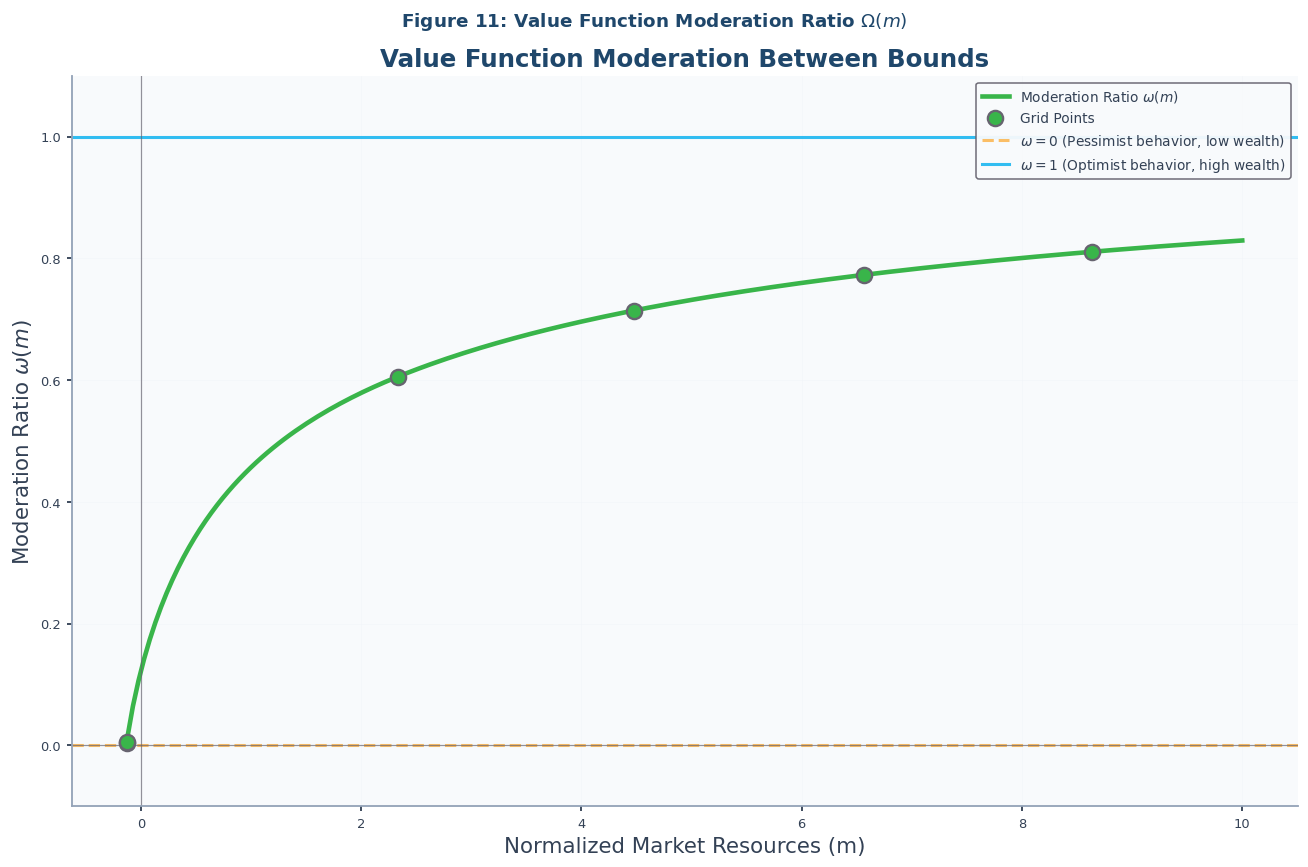

In [13]:
# | label: fig:value-moderation-ratio

# Figure 11: Value Function Moderation Ratio
plot_moderation_ratio(
    solution=IndShockMoMApproxSol,
    title=r"Figure 11: Value Function Moderation Ratio $\Omega(m)$",
    subtitle="Value Function Moderation Between Bounds",
    m_max=10,
    grid_type=GridType.VALUE,
)

```{hint} Value Function Moderation Interpretation
$\valModRte \to 1$ at high wealth (low uncertainty cost), $\valModRte \to 0$ at low wealth (high uncertainty cost). The pattern confirms uncertainty's welfare cost diminishes with wealth.
```

### Figure 12: Cusp Point Visualization

The **cusp point** (Eq. {eq}`eq:mNrmCusp`) is where optimist and tighter upper bounds intersect:

$$
\mNrmCusp = \mNrmMin + \frac{\MPCmin \cdot \hNrmEx}{\MPCmax - \MPCmin}
$$

Below the cusp, the tighter bound ($\MPCmax$ slope) constrains; above, the optimist bound constrains. See `IndShockMoMCuspConsumerType` for the three-piece implementation.

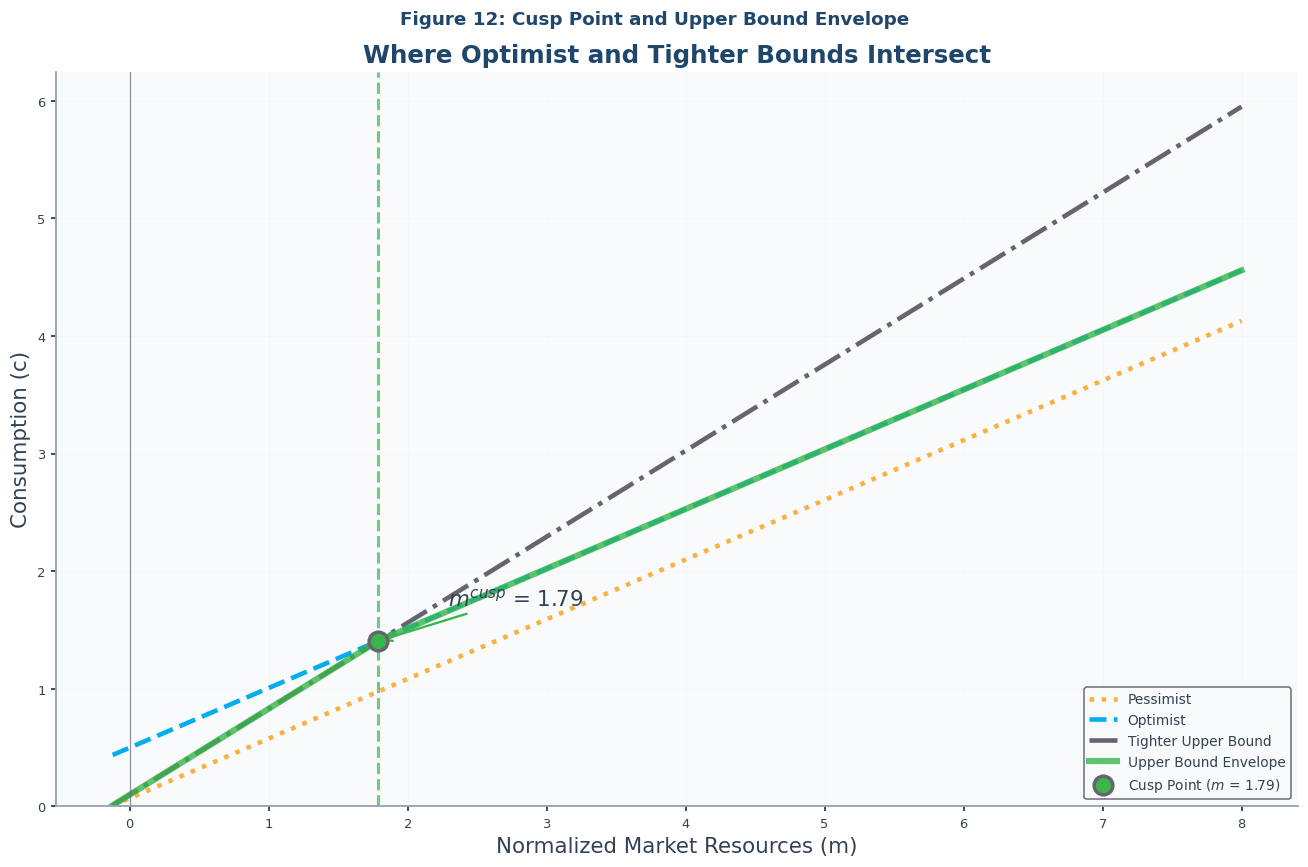

In [14]:
# | label: fig:cusp-point

# Figure 12: Cusp Point Visualization
plot_cusp_point(
    solution=IndShockMoMApproxSol,
    title="Figure 12: Cusp Point and Upper Bound Envelope",
    subtitle="Where Optimist and Tighter Bounds Intersect",
    m_max=8,
)

```{hint} Cusp Point Interpretation
Below cusp: MPC near $\MPCmax$, tighter bound constrains. Above cusp: behavior approaches optimist ($\MPCmin$), optimist bound constrains. The envelope is the minimum of both bounds.
```

## Further Extensions: Stochastic Rate of Return

With i.i.d. returns, {cite:t}`Samuelson1969` and {cite:t}`Merton1969,Merton1971` show the consumption function remains linear for consumers without labor income. MoM extends directly by substituting the stochastic-return MPC {cite:p}`BBZ2016SkewedWealth,CRRA-RateRisk`. Serially correlated returns remain for future research.

### Figure 13: Stochastic Returns Comparison

[](#fig:stochastic-bounds) compares bounds under deterministic and stochastic returns using `IndShockMoMStochasticRConsumerType`.

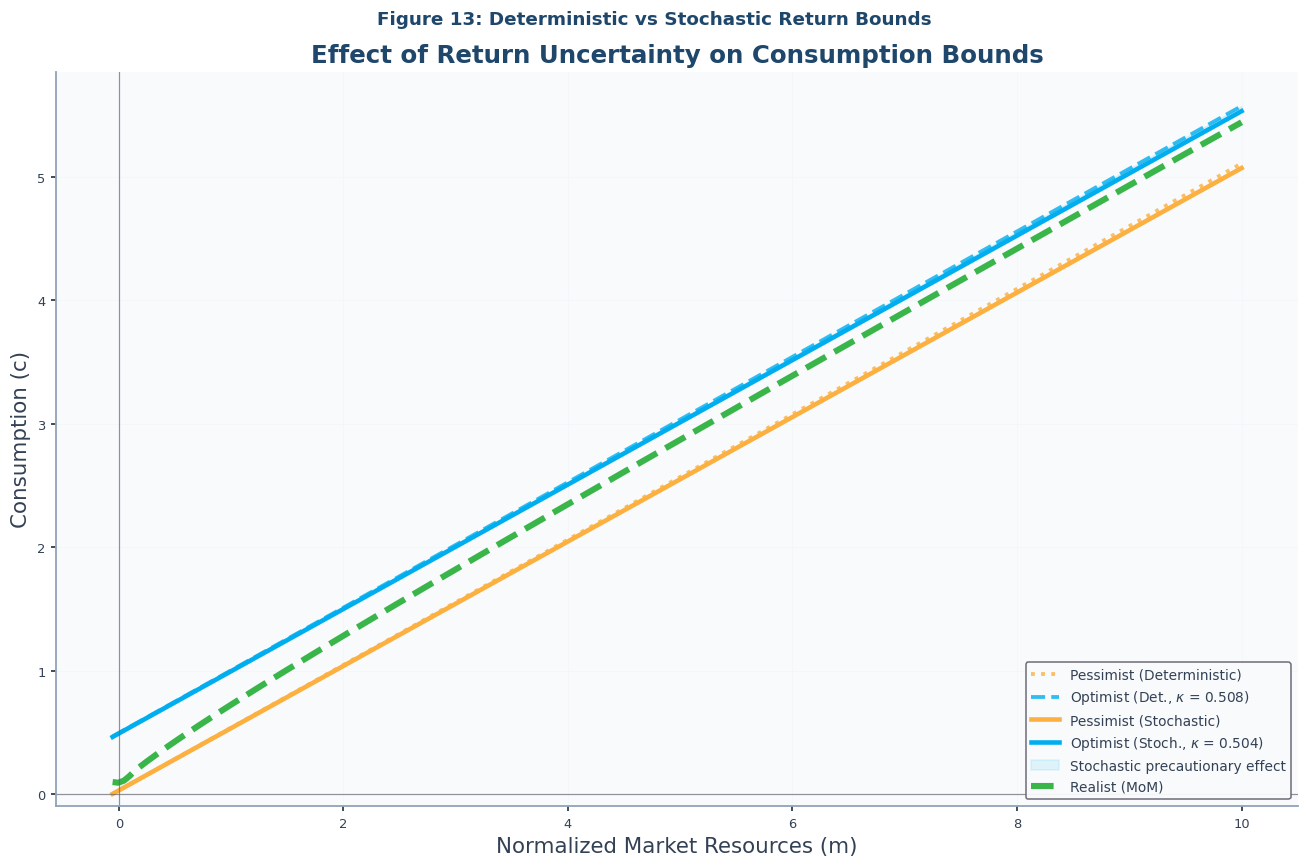

In [15]:
# | label: fig:stochastic-bounds

# Solve model with stochastic returns (mean-preserving spread)
stoch_params = params.copy()
stoch_params["RiskyAvg"] = params["Rfree"][0]  # Same mean as Rfree (scalar)
stoch_params["RiskyStd"] = (
    0.20  # 20% standard deviation (must satisfy β*E[R^{1-ρ}] < 1)
)

IndShockStochR = IndShockMoMStochasticRConsumerType(**stoch_params)
IndShockStochR.solve()
IndShockStochRSol = IndShockStochR.solution[0]

# Figure 13: Stochastic Returns Comparison
plot_stochastic_bounds(
    solution=IndShockStochRSol,
    title="Figure 13: Deterministic vs Stochastic Return Bounds",
    subtitle="Effect of Return Uncertainty on Consumption Bounds",
    m_max=10,
)

```{hint} Stochastic Returns Interpretation
Deterministic optimist uses $\MPCmin = 1 - (\DiscFac \Rfree)^{1/\CRRA}$; stochastic optimist uses $\MPCmin = 1 - (\DiscFac \Ex[\Risky^{1-\CRRA}])^{1/\CRRA}$. Return uncertainty raises MPC and narrows the feasible region. See {ref}`stochastic-returns-mgf-derivation` for the MGF derivation.
```

## Summary

MoM solves the extrapolation problem by interpolating a **moderation ratio** via an asymptotically linear **logit transformation**, ensuring solutions respect theoretical bounds by construction.

**Key Advantages**:

* **Theoretical Consistency**: Prevents negative precautionary saving.
* **Numerical Stability**: Robust solutions via bounded transformations.
* **Computational Efficiency**: Builds on EGM with minimal overhead.

For complete theoretical development see {ref}`the-method-of-moderation`.